Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it.


o The repository has several datasets. For this case study, please use the Electronics dataset.

o The host page has several pointers to scripts and other examples that can help with parsing the datasets.

o The data set consists of:
● 7,824,482 Ratings (1-5) for Electronics products.
● Other metadata about products. Please see the description of the fields available on the web page cited above.

Steps -
1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )
3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)
4. Build Popularity Recommender model.
5. Build Collaborative Filtering model.
6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)
7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.
8. Summarise your insights.

In [3]:
import matplotlib.pyplot as plt

import pandas
from sklearn.cross_validation import train_test_split
import numpy as np
import time


# 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [4]:

#using electronics meta file to get title for the dataset which has product id, userid and ratings

import pandas as pd
import gzip

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('meta_Electronics.json.gz')

In [5]:
df.head()

,asin,imUrl,description,categories,title,price,salesRank,related,brand
0,0132793040,http://ecx.images-amazon.com/images/I/31JIPhp%...,The Kelby Training DVD Mastering Blend Modes i...,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Mastering Blend Modes in A...,NaN,NaN,NaN,NaN
1,0321732944,http://ecx.images-amazon.com/images/I/31uogm6Y...,NaN,"[[Electronics, Computers & Accessories, Cables...",Kelby Training DVD: Adobe Photoshop CS5 Crash ...,NaN,NaN,NaN,NaN
2,0439886341,http://ecx.images-amazon.com/images/I/51k0qa8f...,Digital Organizer and Messenger,"[[Electronics, Computers & Accessories, PDAs, ...",Digital Organizer and Messenger,8.15,{'Electronics': 144944},"{'also_viewed': ['0545016266', 'B009ECM8QY', '...",NaN
3,0511189877,http://ecx.images-amazon.com/images/I/41HaAhbv...,The CLIKR-5 UR5U-8780L remote control is desig...,"[[Electronics, Accessories & Supplies, Audio &...",CLIKR-5 Time Warner Cable Remote Control UR5U-...,23.36,NaN,"{'also_viewed': ['B001KC08A4', 'B00KUL8O0W', '...",NaN
4,0528881469,http://ecx.images-amazon.com/images/I/51FnRkJq...,"Like its award-winning predecessor, the Intell...","[[Electronics, GPS & Navigation, Vehicle GPS, ...",Rand McNally 528881469 7-inch Intelliroute TND...,299.99,NaN,"{'also_viewed': ['B006ZOI9OY', 'B00C7FKT2A', '...",NaN


In [6]:
df.shape

(498196, 9)

In [7]:
columns=['user_id','prod_id','rating','timestamp']
electronics_df = pd.read_csv('ratings_Electronics.csv',names = columns)

In [8]:
electronics_df.shape

(7824482, 4)

In [9]:
electronics_df.head()

,user_id,prod_id,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [10]:
#discarding the last column
electronics_df.drop('timestamp', axis=1, inplace=True)

In [11]:
electronics_df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [12]:
df_title = df.iloc[:,[0,4]]
df_title.head()

,asin,title
0,0132793040,Kelby Training DVD: Mastering Blend Modes in A...
1,0321732944,Kelby Training DVD: Adobe Photoshop CS5 Crash ...
2,0439886341,Digital Organizer and Messenger
3,0511189877,CLIKR-5 Time Warner Cable Remote Control UR5U-...
4,0528881469,Rand McNally 528881469 7-inch Intelliroute TND...


In [13]:
#'how' in merge is left because we want to retain all the rows of electronics_df
electronics_merge_df = pd.merge(electronics_df, df_title, how='left', right_on='asin', left_on='prod_id')

In [14]:
electronics_merge_df.head()

,user_id,prod_id,rating,asin,title
0,AKM1MP6P0OYPR,0132793040,5.0,0132793040,Kelby Training DVD: Mastering Blend Modes in A...
1,A2CX7LUOHB2NDG,0321732944,5.0,0321732944,Kelby Training DVD: Adobe Photoshop CS5 Crash ...
2,A2NWSAGRHCP8N5,0439886341,1.0,0439886341,Digital Organizer and Messenger
3,A2WNBOD3WNDNKT,0439886341,3.0,0439886341,Digital Organizer and Messenger
4,A1GI0U4ZRJA8WN,0439886341,1.0,0439886341,Digital Organizer and Messenger


In [15]:
electronics_merge_df.shape

(7824482, 5)

In [16]:
electronics_merge_df.drop('asin', axis=1, inplace=True)

In [17]:
#shortening the dataframe name
em_df= electronics_merge_df

In [18]:
print(em_df.shape)
print(em_df['user_id'].unique().shape)
print(em_df['prod_id'].unique().shape)

(7824482, 4)
(4201696,)
(476002,)


We can see that the number of unique users are much larger than the number of unique items.

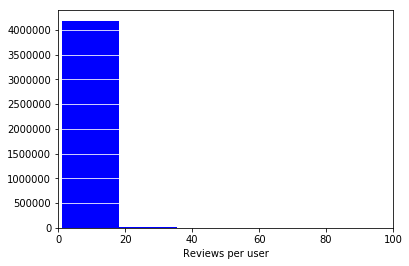

In [19]:
fig, ax = plt.subplots()
reviews_per_user=em_df.groupby(['user_id'])['prod_id'].count()
ax.set(xlim=(0,100), xlabel='Reviews per user')
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')
plt.hist(reviews_per_user, bins=30, log=False, color="Blue")
plt.show()



# 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [20]:
small_df = em_df.groupby(['user_id']).count()>49
small_df.shape

(4201696, 3)

In [21]:
small_df= small_df.loc[small_df.prod_id == True]
small_df.shape

(1540, 3)

In [22]:

small_df = pd.DataFrame(small_df).reset_index()


In [23]:
dense_df = em_df.loc[em_df['user_id'].isin(small_df['user_id'])]


In [24]:
dense_df.head(10)

,user_id,prod_id,rating,title
94,A3BY5KCNQZXV5U,0594451647,5.0,Barnes &amp; Noble HDTV Adapter Kit for NOOK H...
118,AT09WGFUM934H,0594481813,3.0,Barnes &amp; Noble OV/HB-ADP Universal Power Kit
177,A32HSNCNPRUMTR,0970407998,1.0,Audiovox Surface SURF402 Wet/Dry Screen Wipes
178,A17HMM1M7T9PJ1,0970407998,4.0,Audiovox Surface SURF402 Wet/Dry Screen Wipes
492,A3CLWR1UUZT6TG,0972683275,5.0,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...
631,A3TAS1AG6FMBQW,0972683275,5.0,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...
1003,A2Y4H3PXB07WQI,0972683275,4.0,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...
1138,A25RTRAPQAJBDJ,0972683275,5.0,VideoSecu 24&quot; Long Arm TV Wall Mount Low ...
1310,A3LDPF5FMB782Z,1400501466,5.0,"Barnes &amp; Noble NOOK Tablet 16gb (Color, BN..."
1322,A1A5KUIIIHFF4U,1400501466,1.0,"Barnes &amp; Noble NOOK Tablet 16gb (Color, BN..."


# 3. Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

In [25]:
train_data, test_data = train_test_split(dense_df, test_size = 0.30, random_state=0)
print(train_data.head(5))


                user_id     prod_id  rating  \
6595853  A2BYV7S1QP2YIG  B009EAHVTA     5.0   
4738241   AB094YABX21WQ  B0056XCEAA     1.0   
4175596  A3D0UM4ZD2CMAW  B004I763AW     5.0   
3753016   AATWFX0ZZSE6C  B0040NPHMO     3.0   
1734767  A1NNMOD9H36Q8E  B0015VW3BM     4.0   

                                                     title  
6595853      Tumi Luggage Slim Zip Top Crossbody for I-Pad  
4738241  Ezfoto 58mm Lens Cap for Canon Lens, replaces ...  
4175596  G.Skill DDR3 PC3-12800 RipjawsX Series for San...  
3753016  Grace Digital GDI-IR2550P Pandora Wi-Fi Intern...  
1734767  Sony DVP-NS700H/B 1080p Upscaling DVD Player, ...  


In [26]:
train_data.shape

(88109, 4)

In [27]:
test_data.shape

(37762, 4)

# 4. Build Popularity Recommender model.

In [28]:
train_data_grouped = train_data.groupby('prod_id').mean().reset_index()
print(train_data_grouped.head(5))
#Sort the products based upon recommendation score
train_data_sort = train_data_grouped.sort_values(['rating','prod_id'], ascending = [0,1])
train_data_sort.head(5)

      prod_id  rating
0  0594451647     5.0
1  0594481813     3.0
2  0970407998     1.0
3  0972683275     5.0
4  1400501466     4.5


,prod_id,rating
0,0594451647,5.0
3,0972683275,5.0
6,1400532620,5.0
9,1400698987,5.0
10,1685560148,5.0


In [29]:
pred_df = test_data[['user_id', 'prod_id', 'rating']]
pred_df.rename(columns = {'rating' : 'true_ratings'}, inplace=True)
print(pred_df.head(5))
pred_df = pred_df.merge(train_data_sort,left_on='prod_id', right_on = 'prod_id')
pred_df.rename(columns = {'rating' : 'predicted_ratings'}, inplace = True)
print(pred_df.head(5))

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


                user_id     prod_id  true_ratings
6730391  A3JU990UTN5RQP  B009UHO1L8           5.0
3509543  A2VJ5ALN1BIV3B  B003PNIQCI           5.0
169753    A2NQMVTQ4PVLL  B00006B7DA           4.0
7637572  A25UZ7MA72SMKM  B00FH66AW4           4.0
5490140   A680RUE1FDO8B  B006UAJ690           5.0
          user_id     prod_id  true_ratings  predicted_ratings
0   A2NQMVTQ4PVLL  B00006B7DA           4.0           4.363636
1     AD8DLOGHAXL  B00006B7DA           5.0           4.363636
2  A2SL5IW096Z2BL  B00006B7DA           5.0           4.363636
3   APOGXH3A74CM3  B00006B7DA           5.0           4.363636
4  A1OES7R7FDAT2L  B00006B7DA           5.0           4.363636



Here we are comparing only the product-ids that are present in both test and train data cause merge will happen only if the prod_id's match.

In [30]:
import sklearn.metrics as met
from math import sqrt
MSE = met.mean_squared_error(pred_df['true_ratings'], pred_df['predicted_ratings'])
print('The RMSE value for Popularity Recommender model is', sqrt(MSE))

The RMSE value for Popularity Recommender model is 1.092161482923713


In [31]:
def create_m(train_data, item_id, rating):
        
        
        #Get the mean rating for each unique product as recommendation score
        train_data_grouped = train_data.groupby([item_id]).agg({rating: 'mean'}).reset_index()
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['rating', item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['rating'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        popularity_recommendations = train_data_sort.head(10)
        return popularity_recommendations

In [32]:
def recommend(user_id,popularity_recommendations):    
        user_recommendations = popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations

In [33]:

import Recommenders as rm
popularity_recommendations = create_m(train_data,'prod_id','rating')

In [34]:
user_id = 'A2NQMVTQ4PVLL'
recommend(user_id, popularity_recommendations)

,user_id,prod_id,rating,Rank
0,A2NQMVTQ4PVLL,0594451647,5.0,1.0
3,A2NQMVTQ4PVLL,0972683275,5.0,2.0
6,A2NQMVTQ4PVLL,1400532620,5.0,3.0
9,A2NQMVTQ4PVLL,1400698987,5.0,4.0
10,A2NQMVTQ4PVLL,1685560148,5.0,5.0
12,A2NQMVTQ4PVLL,787988002X,5.0,6.0
13,A2NQMVTQ4PVLL,8862935307,5.0,7.0
16,A2NQMVTQ4PVLL,9573212919,5.0,8.0
24,A2NQMVTQ4PVLL,B000001OKH,5.0,9.0
26,A2NQMVTQ4PVLL,B000001OM4,5.0,10.0


# 5. Build Collaborative Filtering model.

In [ ]:
from surprise import Reader, Dataset, SVD, evaluate,accuracy,GridSearch

from surprise.model_selection import GridSearchCV

In [ ]:
#A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0.5, 5.0))

# The columns must correspond to user id, item id and ratings (in that order).
data_t = Dataset.load_from_df(E_Ratings_df[['user_id', 'prod_id', 'rating']],reader)

#data_t.split(n_folds=2)